In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [132]:
import pickle
import spacy
import scattertext as st
import re

import spacy
#from spacy import displacy
#from spacy.symbols import amod
from spacy.lang.en.stop_words import STOP_WORDS

from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import pyLDAvis
import pyLDAvis.sklearn

import pandas as pd
import numpy as np

import swat
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import nltk
#nltk.download()
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string

import pyflux as pf
from fbprophet import Prophet

import calendar

# Data Preprocessing.
### Skip this step to go to analysis.

In [48]:
with open('../../data/blogger_com_data_330677_11_clean_sentiment_v_pl_normalized.pkl', 'rb') as picklefile:
    df = pickle.load(picklefile)

In [50]:
polarity = df[['blogger_id', 'date', 'polarity_neg_post', 'polarity_pos_posts', 'polarity_compound_post']]

In [51]:
polarity

blogger_id       date  polarity_neg_post  polarity_pos_posts  \
0           4162441 2004-08-19              0.000               0.496   
13          4157968 2004-08-19              0.040               0.213   
17          4278694 2004-08-19              0.189               0.148   
69          4261114 2004-08-19              0.151               0.282   
79          4215047 2004-08-19              0.192               0.203   
...             ...        ...                ...                 ...   
50463676    2999514 1999-02-12              0.139               0.000   
50482996    2999514 1999-04-01              0.000               0.000   
50502316    2999514 1999-06-05              0.000               0.000   
50521636    2999514 1999-12-16              0.000               0.108   
50541018    4246739 2006-08-23              0.124               0.196   

          polarity_compound_post  
0                         0.9894  
13                        0.9900  
17                       -0.6093  
69                        0.9859  
79                        0.0181  
...                          ...  
50463676                 -0.5719  
50482996                  0.0000  
50502316                  0.0000  
50521636                  0.5574  
50541018                  0.2023  

[330676 rows x 5 columns]

In [52]:
with open('../../data/blogger_com_data_330676_polarity.pkl', 'wb') as picklefile:
    pickle.dump(polarity, picklefile)

# Time Series

In [124]:
with open('../../data/blogger_com_data_330676_polarity.pkl', 'rb') as picklefile:
    polarity = pickle.load(picklefile)

In [143]:
#for scatterplot
def get_polarity_data(df, blogger_id='4162441'):
    
    try:
    
        df_sub = df[df['blogger_id']==blogger_id].sort_values(by='date', ascending = True)

        if df_sub.shape[0] > 5:

            df_sub.drop('blogger_id', axis=1, inplace=True)
            df_sub.set_index('date', inplace=True)

            df_sub['MA_pos'] = df_sub['polarity_pos_posts'].rolling(window=3).mean()
            df_sub['MA_neg'] = df_sub['polarity_neg_post'].rolling(window=3).mean()

            df_sub = df_sub.iloc[2:]
            df_sub = df_sub.reset_index()
            
            df_sub['month'] =   df_sub['date'].dt.month
            
            df_sub['month'] = df_sub['month'].apply(lambda x: calendar.month_abbr[x])

            return df_sub

        else:

            print('Sorry, not enough posts yet, make it up to 6.')
    except:
        
        print('Sorry, do not see your ID in the system.')

In [144]:
#for time series
def get_polarity_data2(df, blogger_id='4162441'):
    
    try:
    
        df_sub = df[df['blogger_id']==blogger_id].sort_values(by='date', ascending = True)

        if df_sub.shape[0] > 5:

            df_sub.drop('blogger_id', axis=1, inplace=True)
            df_sub.set_index('date', inplace=True)

            df_sub['MA_pos'] = df_sub['polarity_pos_posts'].rolling(window=3).mean()
            df_sub['MA_neg'] = df_sub['polarity_neg_post'].rolling(window=3).mean()

            df_sub = df_sub.iloc[2:]

            return df_sub

        else:

            print('Sorry, not enough posts yet, make it up to 6.')
    except:
        
        print('Sorry, do not see your ID in the ststem.')
        

In [129]:
blogger_id = '1270648'

In [145]:
df = get_polarity_data2(polarity, blogger_id=blogger_id)
df

polarity_neg_post  polarity_pos_posts  polarity_compound_post  \
date                                                                        
2001-03-31              0.058               0.278                  0.9803   
2001-04-03              0.000               0.709                  0.9042   
2001-04-07              0.357               0.000                 -0.7371   
2001-04-09              0.106               0.239                  0.7430   
2001-04-10              0.119               0.553                  0.8625   
...                       ...                 ...                     ...   
2004-07-12              0.000               0.000                  0.0000   
2004-07-16              0.000               0.000                  0.0000   
2004-07-17              0.130               0.225                  0.7351   
2004-07-20              0.167               0.057                 -0.4215   
2004-07-29              0.000               0.559                  0.7650   

              MA_pos    MA_neg  
date                            
2001-03-31  0.237667  0.092000  
2001-04-03  0.400667  0.053333  
2001-04-07  0.329000  0.138333  
2001-04-09  0.316000  0.154333  
2001-04-10  0.264000  0.194000  
...              ...       ...  
2004-07-12  0.118000  0.114333  
2004-07-16  0.054333  0.040667  
2004-07-17  0.075000  0.043333  
2004-07-20  0.094000  0.099000  
2004-07-29  0.280333  0.099000  

[798 rows x 5 columns]

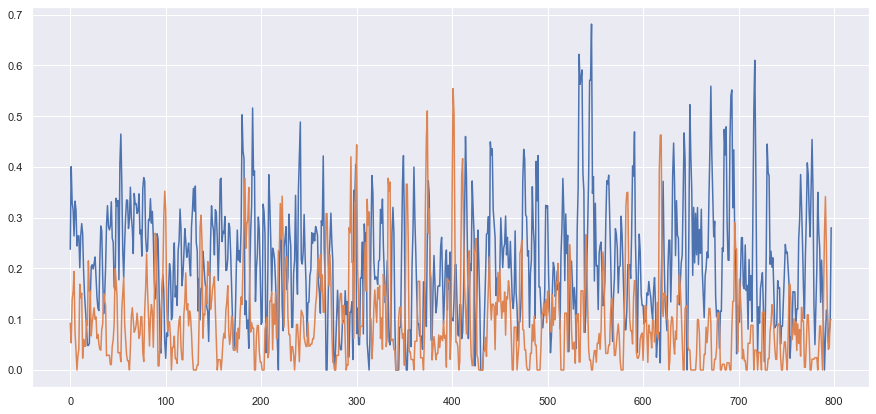

In [131]:
plt.figure(figsize=(15,7))
plt.plot(df.index, df['MA_pos'])
plt.plot(df.index, df['MA_neg']);

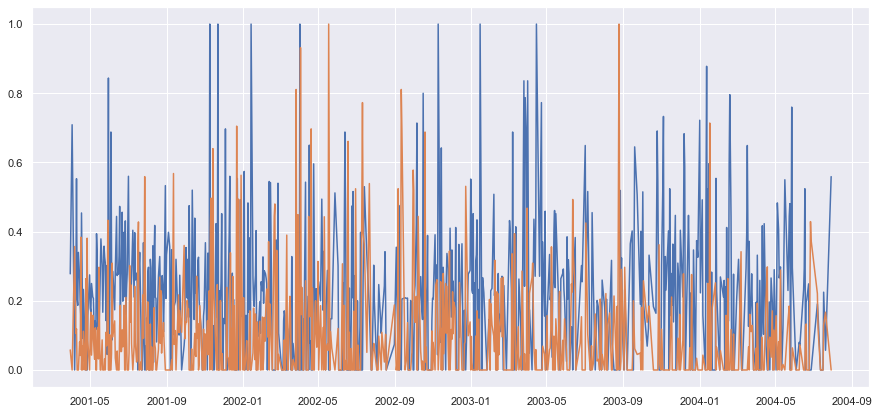

In [30]:
plt.figure(figsize=(15,7))
plt.plot(df.index, df['polarity_pos_posts'])
plt.plot(df.index, df['polarity_neg_post']);

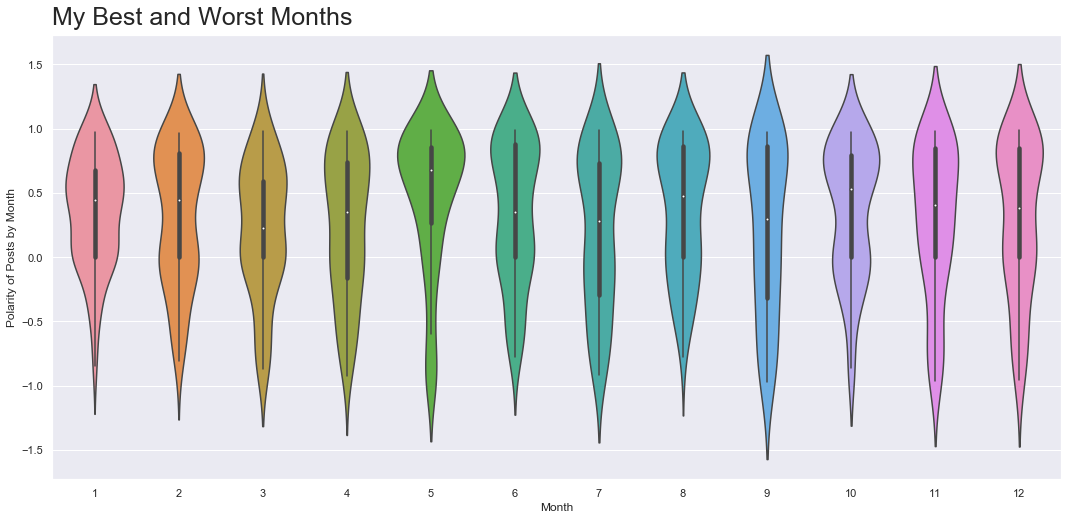

In [219]:
# violinplot months to determine variance and range
plt.figure(figsize=(15,7))
sns.set()
sns.violinplot(x=df.index.month, y=df.polarity_compound_post)
plt.xlabel("Month")
plt.ylabel("Polarity of Posts by Month")
plt.tight_layout()
plt.title('My Best and Worst Months', fontsize=25, pad=10, loc = 'left');

In [32]:
import plotly.express as px

fig = px.violin(df, y="polarity_compound_post", x=df.index.month, box=True, points="all",
          hover_data=df.columns)
fig.show()

In [72]:
df1

date  polarity_neg_post  polarity_pos_posts  polarity_compound_post  \
0   2001-03-31              0.058               0.278                  0.9803   
1   2001-04-03              0.000               0.709                  0.9042   
2   2001-04-07              0.357               0.000                 -0.7371   
3   2001-04-09              0.106               0.239                  0.7430   
4   2001-04-10              0.119               0.553                  0.8625   
..         ...                ...                 ...                     ...   
793 2004-07-12              0.000               0.000                  0.0000   
794 2004-07-16              0.000               0.000                  0.0000   
795 2004-07-17              0.130               0.225                  0.7351   
796 2004-07-20              0.167               0.057                 -0.4215   
797 2004-07-29              0.000               0.559                  0.7650   

       MA_pos    MA_neg month  
0    0.237667  0.092000   Mar  
1    0.400667  0.053333   Apr  
2    0.329000  0.138333   Apr  
3    0.316000  0.154333   Apr  
4    0.264000  0.194000   Apr  
..        ...       ...   ...  
793  0.118000  0.114333   Jul  
794  0.054333  0.040667   Jul  
795  0.075000  0.043333   Jul  
796  0.094000  0.099000   Jul  
797  0.280333  0.099000   Jul  

[798 rows x 7 columns]

In [76]:
import plotly.graph_objects as go

import pandas as pd

fig = go.Figure()

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
#months = [1,2,3,4,5,6,7,8,9,10,11,12]
for month in months:

    fig.add_trace(go.Violin(x=df1['month'][df1['month'] == month],
                            y=df1['polarity_compound_post'][df1['month'] == month],
                            name=month,
                            box_visible=True,
                            meanline_visible=True))

fig.show()

# Profet

In [146]:
df

polarity_neg_post  polarity_pos_posts  polarity_compound_post  \
date                                                                        
2001-03-31              0.058               0.278                  0.9803   
2001-04-03              0.000               0.709                  0.9042   
2001-04-07              0.357               0.000                 -0.7371   
2001-04-09              0.106               0.239                  0.7430   
2001-04-10              0.119               0.553                  0.8625   
...                       ...                 ...                     ...   
2004-07-12              0.000               0.000                  0.0000   
2004-07-16              0.000               0.000                  0.0000   
2004-07-17              0.130               0.225                  0.7351   
2004-07-20              0.167               0.057                 -0.4215   
2004-07-29              0.000               0.559                  0.7650   

              MA_pos    MA_neg  
date                            
2001-03-31  0.237667  0.092000  
2001-04-03  0.400667  0.053333  
2001-04-07  0.329000  0.138333  
2001-04-09  0.316000  0.154333  
2001-04-10  0.264000  0.194000  
...              ...       ...  
2004-07-12  0.118000  0.114333  
2004-07-16  0.054333  0.040667  
2004-07-17  0.075000  0.043333  
2004-07-20  0.094000  0.099000  
2004-07-29  0.280333  0.099000  

[798 rows x 5 columns]

In [147]:
df.iloc[:,2]#.reset_index()

date
2001-03-31    0.9803
2001-04-03    0.9042
2001-04-07   -0.7371
2001-04-09    0.7430
2001-04-10    0.8625
               ...  
2004-07-12    0.0000
2004-07-16    0.0000
2004-07-17    0.7351
2004-07-20   -0.4215
2004-07-29    0.7650
Name: polarity_compound_post, Length: 798, dtype: float64

In [134]:
int(np.floor(df.shape[0]*0.2))

159

In [148]:
def fb_profet(df, n_col=2):
    
    df_profet = df.iloc[:,n_col].reset_index()
    df_profet.rename(columns={'date':'ds', df_profet.columns[1]:'y'}, inplace=True)
    
    model = Prophet()
    model.fit(df_profet);
    
    future = model.make_future_dataframe(periods=int(np.floor(df.shape[0]*0.2)))
    forecast = model.predict(future)
    
    return model, forecast
    

In [178]:
#!!!
#df = get_polarity_data2(polarity, blogger_id=blogger_id)

neg_model, neg_forecast = fb_profet(df, n_col=0)
pos_model, pos_forecast = fb_profet(df, n_col=1)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


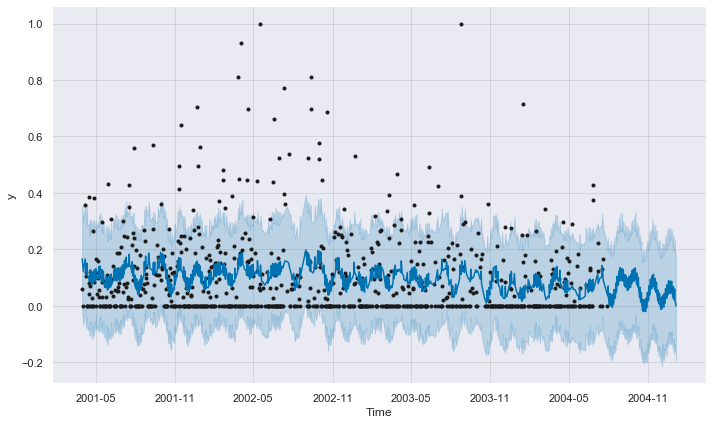

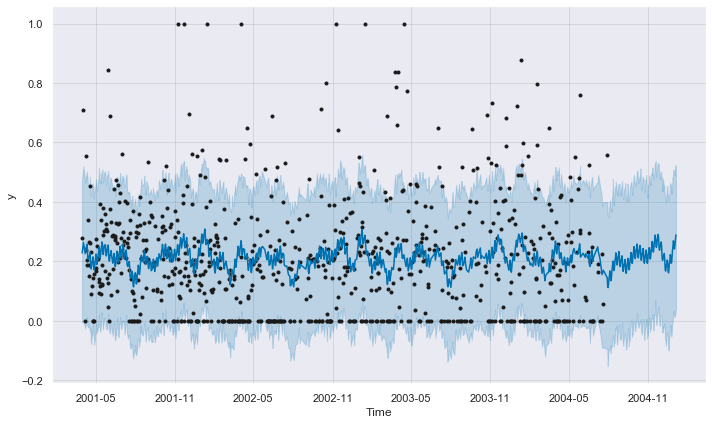

In [179]:
model, forecast = fb_profet(df, n_col=2)

neg_model.plot(neg_forecast, xlabel='Time')
pos_model.plot(pos_forecast, xlabel='Time');

In [184]:
neg_forecast

ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0   2001-03-31  0.099129   -0.019157    0.350952     0.099129     0.099129   
1   2001-04-03  0.099285   -0.068878    0.296187     0.099285     0.099285   
2   2001-04-07  0.099494   -0.010186    0.365632     0.099494     0.099494   
3   2001-04-09  0.099599   -0.074849    0.300658     0.099599     0.099599   
4   2001-04-10  0.099651   -0.079881    0.290736     0.099651     0.099651   
..         ...       ...         ...         ...          ...          ...   
952 2004-12-31  0.045475   -0.160723    0.192755     0.044003     0.046947   
953 2005-01-01  0.045389   -0.135899    0.234517     0.043906     0.046870   
954 2005-01-02  0.045303   -0.160715    0.197131     0.043809     0.046806   
955 2005-01-03  0.045217   -0.162343    0.190626     0.043707     0.046738   
956 2005-01-04  0.045132   -0.193547    0.173080     0.043594     0.046665   

     additive_terms  additive_terms_lower  additive_terms_upper    weekly  \
0          0.067362              0.067362              0.067362  0.030697   
1          0.023088              0.023088              0.023088 -0.017321   
2          0.067161              0.067161              0.067161  0.030697   
3          0.023630              0.023630              0.023630 -0.007632   
4          0.010762              0.010762              0.010762 -0.017321   
..              ...                   ...                   ...       ...   
952       -0.023216             -0.023216             -0.023216 -0.011069   
953        0.014251              0.014251              0.014251  0.030697   
954       -0.028791             -0.028791             -0.028791 -0.008133   
955       -0.032322             -0.032322             -0.032322 -0.007632   
956       -0.045780             -0.045780             -0.045780 -0.017321   

     weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper  \
0        0.030697      0.030697  0.036665      0.036665      0.036665   
1       -0.017321     -0.017321  0.040410      0.040410      0.040410   
2        0.030697      0.030697  0.036464      0.036464      0.036464   
3       -0.007632     -0.007632  0.031262      0.031262      0.031262   
4       -0.017321     -0.017321  0.028084      0.028084      0.028084   
..            ...           ...       ...           ...           ...   
952     -0.011069     -0.011069 -0.012146     -0.012146     -0.012146   
953      0.030697      0.030697 -0.016446     -0.016446     -0.016446   
954     -0.008133     -0.008133 -0.020658     -0.020658     -0.020658   
955     -0.007632     -0.007632 -0.024690     -0.024690     -0.024690   
956     -0.017321     -0.017321 -0.028458     -0.028458     -0.028458   

     multiplicative_terms  multiplicative_terms_lower  \
0                     0.0                         0.0   
1                     0.0                         0.0   
2                     0.0                         0.0   
3                     0.0                         0.0   
4                     0.0                         0.0   
..                    ...                         ...   
952                   0.0                         0.0   
953                   0.0                         0.0   
954                   0.0                         0.0   
955                   0.0                         0.0   
956                   0.0                         0.0   

     multiplicative_terms_upper      yhat  
0                           0.0  0.166491  
1                           0.0  0.122374  
2                           0.0  0.166655  
3                           0.0  0.123229  
4                           0.0  0.110413  
..                          ...       ...  
952                         0.0  0.022260  
953                         0.0  0.059640  
954                         0.0  0.016512  
955                         0.0  0.012896  
956                         0.0 -0.000648  

[957 rows x 19 columns]

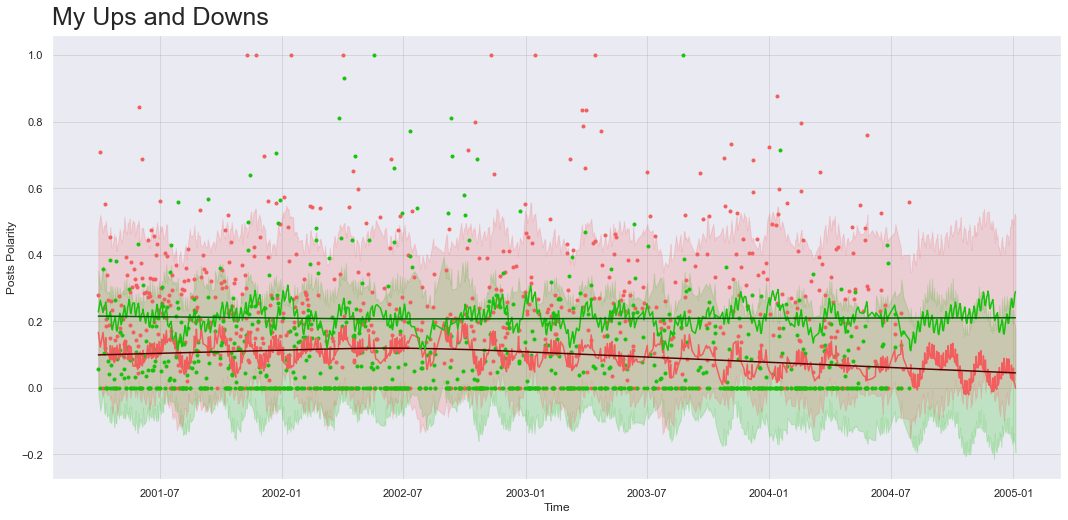

In [217]:
sns.set()

plt.figure(figsize=(15,7), facecolor='w')
plt.plot(pos_model.history['ds'].dt.to_pydatetime(), pos_model.history['y'], 'k.', c='#F25E5E')
plt.plot(neg_model.history['ds'].dt.to_pydatetime(), neg_model.history['y'], 'k.', c='#18C20C')
plt.plot(neg_forecast['ds'], neg_forecast['yhat'], ls='-', c='#F25E5E')
plt.plot(neg_forecast['ds'], neg_forecast['trend'], ls='-', c='#590404')
plt.plot(pos_forecast['ds'], pos_forecast['yhat'], ls='-', c='#18C20C')
plt.plot(pos_forecast['ds'], pos_forecast['trend'], ls='-', c='#026105')
plt.fill_between(neg_forecast['ds'], neg_forecast['yhat_lower'], neg_forecast['yhat_upper'], 
                 color='#18C20C', alpha=0.2)
plt.fill_between(pos_forecast['ds'], pos_forecast['yhat_lower'], pos_forecast['yhat_upper'], 
                 color='#F25E5E', alpha=0.2)
plt.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
plt.xlabel('Time')
plt.ylabel("Posts Polarity")
plt.tight_layout()
plt.title('My Ups and Downs', fontsize=25, pad=10, loc = 'left');

In [220]:
import pickle
import plotly.offline as off
off.init_notebook_mode(connected=False)

import plotly.figure_factory as ff
import plotly.graph_objects as go

In [ ]:
    for emotion in selected_dropdown_value:
        trace1.append(go.Scatter(x=df_sub[df_sub['variable'] == emotion].index,
                                 y=df_sub[df_sub['variable'] == emotion]['change'],
                                 mode='lines',
                                 opacity=0.4,
                                 name=emotion,
                                 textposition='bottom center'))

In [237]:
fig = go.Figure()
# fig.add_trace(go.Scatter(x=neg_forecast['ds'], y=neg_forecast['yhat'],
#                     mode='lines',
#                     name='lines'))
# fig.add_trace(go.Scatter(x=pos_forecast['ds'], y=pos_forecast['yhat'],
#                     mode='lines',
#                     name='lines'))
# fig.add_trace(go.Scatter(x=neg_forecast['ds'], y=neg_forecast['trend'],
#                     mode='lines',
#                     name='negativity trend'))
# fig.add_trace(go.Scatter(x=pos_forecast['ds'], y=pos_forecast['trend'],
#                     mode='lines',
#                     name='positivity trend'))


#plt.plot(pos_model.history['ds'].dt.to_pydatetime(), pos_model.history['y'], 'k.', c='#F25E5E')
#plt.plot(neg_model.history['ds'].dt.to_pydatetime(), neg_model.history['y'], 'k.', c='#18C20C')

fig.add_trace(go.Scatter(x=pos_model.history['ds'].dt.to_pydatetime(), y=pos_model.history['y'],
                    mode='markers',
                    opacity=0.8,
                    #color='#BCE0BE',
                    marker = dict(size=5, color='#BCE0BE'),
                    name='Positive'))
fig.add_trace(go.Scatter(x=neg_model.history['ds'].dt.to_pydatetime(), y=neg_model.history['y'],
                    mode='markers',
                    #color='#FCB6B7',
                    marker = dict(size=5, color='#FCB6B7'),
                    opacity=0.8,
                    name='Negative'))

fig.add_trace(go.Scatter(
    x=pos_forecast['ds'],
    y=pos_forecast['yhat_lower']+pos_forecast['yhat_upper'],
    fill='toself',
    fillcolor='#BCE0BE',
    line_color='#026105',
    name='Positive Trend',
    showlegend=False,
))

fig.add_trace(go.Scatter(
    x=neg_forecast['ds'],
    y=neg_forecast['yhat_lower']+neg_forecast['yhat_upper'],
    fill='toself',
    fillcolor='#FCB6B7',
    line_color='#590404',
    showlegend=False,
    name='Negative Trend',
))





fig.show()

In [ ]:
annotations.append(dict(xref='paper', yref='paper', x=0.5, y=-0.1,
                              xanchor='center', yanchor='top',
                              text='Source: PewResearch Center & ' +
                                   'Storytelling with data',
                              font=dict(family='Arial',
                                        size=12,
                                        color='rgb(150,150,150)'),
                              showarrow=False))

fig.update_layout(annotations=annotations)


In [238]:
ddv = [1,2,3]
list1 = []
# Draw and append traces for each stock
for month in ddv:
    trace1.append(go.Violin(x=polarity1['month'][polarity1['month'] == month],
                            y=polarity1['polarity_compound_post'][polarity1['month'] == month],
                            name=month))

list1 = [trace1]

NameError: name 'trace1' is not defined

# Pyflux

In [151]:
df

polarity_neg_post  polarity_pos_posts  polarity_compound_post  \
date                                                                        
2001-03-31              0.058               0.278                  0.9803   
2001-04-03              0.000               0.709                  0.9042   
2001-04-07              0.357               0.000                 -0.7371   
2001-04-09              0.106               0.239                  0.7430   
2001-04-10              0.119               0.553                  0.8625   
...                       ...                 ...                     ...   
2004-07-12              0.000               0.000                  0.0000   
2004-07-16              0.000               0.000                  0.0000   
2004-07-17              0.130               0.225                  0.7351   
2004-07-20              0.167               0.057                 -0.4215   
2004-07-29              0.000               0.559                  0.7650   

              MA_pos    MA_neg  
date                            
2001-03-31  0.237667  0.092000  
2001-04-03  0.400667  0.053333  
2001-04-07  0.329000  0.138333  
2001-04-09  0.316000  0.154333  
2001-04-10  0.264000  0.194000  
...              ...       ...  
2004-07-12  0.118000  0.114333  
2004-07-16  0.054333  0.040667  
2004-07-17  0.075000  0.043333  
2004-07-20  0.094000  0.099000  
2004-07-29  0.280333  0.099000  

[798 rows x 5 columns]

In [168]:
df_pyflux = df.iloc[:,2].reset_index()
df_pyflux.rename(columns={'date':'ds', df_pyflux.columns[1]:'y'}, inplace=True)
    
model = pf.ARIMAX(data=df_pyflux,formula='y~1',ar=2,ma=0, integ=1)
fit_model = model.fit()

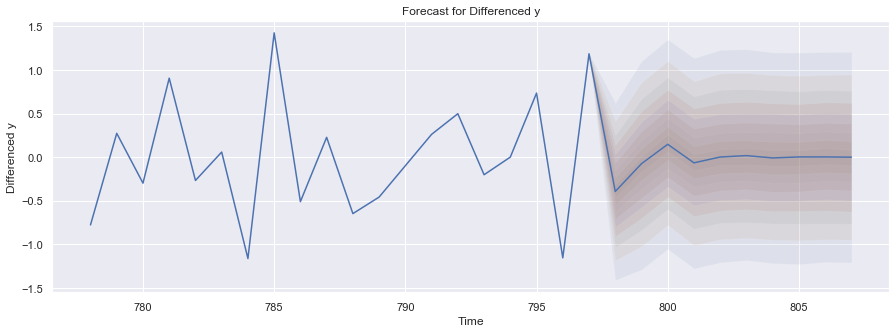

In [169]:
model.plot_predict(h=10, oos_data=df_pyflux, figsize=(15,5))

In [172]:
def ts_pyflux(df, n_col=2):
    
    df_pyflux = df.iloc[:,n_col].reset_index()
    df_pyflux.rename(columns={'date':'ds', df_pyflux.columns[1]:'y'}, inplace=True)
    
    model = pf.ARIMAX(data=df_pyflux,formula='y~1',ar=2,ma=0, integ=1)
    fit_model = model.fit()
    
    
    
    return model, df_pyflux

In [176]:
neg_model, neg_df_pyflux = ts_pyflux(df, n_col=0)
pos_model, pos_df_pyflux = ts_pyflux(df, n_col=1)

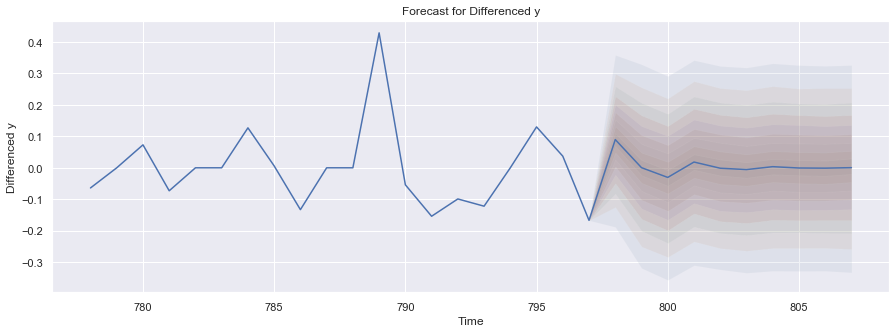

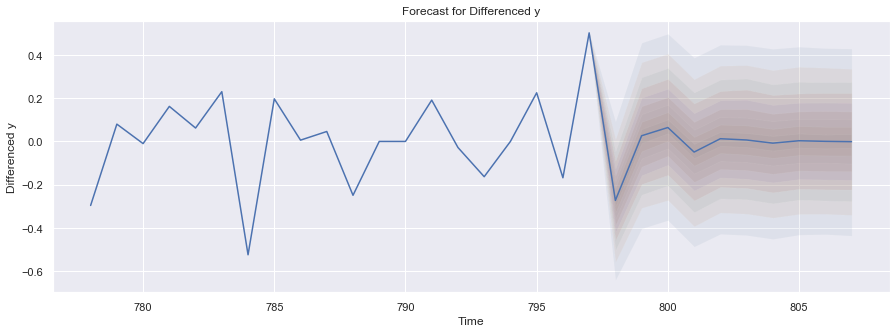

In [177]:
neg_model.plot_predict(h=10, oos_data=neg_df_pyflux, figsize=(15,5))
pos_model.plot_predict(h=10, oos_data=pos_df_pyflux, figsize=(15,5))

In [244]:

# df_pyflux = df.iloc[:,0].reset_index()
# df_pyflux.rename(columns={'date':'ds', df_pyflux.columns[1]:'y'}, inplace=True)
# df_pyflux

In [245]:
# df_pyflux.iloc[-df_pyflux.shape[0]:]

In [246]:
# model = pf.ARIMAX(data=df_pyflux,formula='y~1',ar=2,ma=0, integ=1)

# fit_model = model.fit()
    
# model.plot_predict(h=1,oos_data=df_pyflux.iloc[-df_pyflux.shape[0]:])

In [247]:
# df_pyflux.iloc[-df_pyflux.shape[0]:]

In [248]:
# df_pyflux.shape[0]

In [205]:
# df_pyflux = df.iloc[:,n_col].reset_index()
# df_pyflux.rename(columns={'date':'ds', df_profet.columns[1]:'y'}, inplace=True)